# Funding Rates

This notebook collects funding rate historical data for Binance, Bybit and Hyperliquid since listing for a given symbol, which we choose based from the list of all listings sorted by the first letter. 

In [6]:
import requests
from pybit.unified_trading import HTTP

# Initialize Bybit session (real endpoint, not testnet)
bybit_session = HTTP(testnet=False)

def list_binance_symbols():
    url = "https://fapi.binance.com/fapi/v1/exchangeInfo"
    try:
        response = requests.get(url, timeout=10)
        data = response.json()
        return sorted([s["symbol"] for s in data["symbols"] if s.get("contractType") == "PERPETUAL"])
    except Exception as e:
        print(f"Binance symbol fetch error: {e}")
        return []

def list_bybit_symbols(bybit_session):
    try:
        response = bybit_session.get_instruments_info(category="linear")
        return sorted([item["symbol"] for item in response["result"]["list"]])
    except Exception as e:
        print(f"Bybit symbol fetch error: {e}")
        return []

def list_hyperliquid_symbols():
    url = "https://api.hyperliquid.xyz/info"
    payload = {"type": "meta"}
    try:
        response = requests.post(url, json=payload, timeout=10)
        data = response.json()
        return sorted([coin["name"] for coin in data["universe"]])
    except Exception as e:
        print(f"Hyperliquid symbol fetch error: {e}")
        return []

# --- Helper function to filter by starting letter ---
def prompt_symbol(exchange_name, symbols):
    if not symbols:
        print(f"⚠️ No symbols available for {exchange_name}.")
        return None

    letter = input(f"\n🔤 Enter starting letter for {exchange_name} symbol (e.g. 'B' or 'E'): ").strip().upper()
    filtered = [s for s in symbols if s.startswith(letter)]

    if not filtered:
        print(f"❌ No {exchange_name} symbols found starting with '{letter}'. Showing full list instead.")
        filtered = symbols

    print(f"\n--- {exchange_name} Symbols {'starting with ' + letter if filtered != symbols else '(full list)'} ---")
    print(", ".join(filtered[:50]) + (" ..." if len(filtered) > 50 else ""))
    
    selected = input(f"✅ Enter your desired {exchange_name} symbol: ").strip().upper()
    return selected if selected in symbols else None

# --- Fetch and prompt ---
print("📦 Fetching available symbols...")

binance_symbols = list_binance_symbols()
bybit_symbols = list_bybit_symbols(bybit_session)
hyperliquid_symbols = list_hyperliquid_symbols()

symbol_binance = prompt_symbol("Binance", binance_symbols)
symbol_bybit = prompt_symbol("Bybit", bybit_symbols)
symbol_hyperliquid = prompt_symbol("Hyperliquid", hyperliquid_symbols)


📦 Fetching available symbols...


KeyboardInterrupt: Interrupted by user

Binance BERAUSDT listed on 2025-02-06 15:00:00
Bybit BERAUSDT listed on 2025-02-06 13:16:28
Binance Fetch Complete ✅ Total funding entries: 504
Bybit Fetch Progress: 85%
Bybit Fetch Progress: 90%
Bybit Fetch Progress: 95%
Bybit Fetch Progress: 100%
Bybit Fetch Complete ✅. Total funding entries: 5300
No data between 2025-01-07 15:00:00 and 2025-01-14 15:00:00
No data between 2025-01-14 15:00:00.001000 and 2025-01-21 15:00:00.001000
No data between 2025-01-21 15:00:00.002000 and 2025-01-28 15:00:00.002000
No data between 2025-01-28 15:00:00.003000 and 2025-02-04 15:00:00.003000
Hyperliquid Fetch Progress: 30%
Hyperliquid Fetch Progress: 55%
Hyperliquid Fetch Progress: 85%
Hyperliquid Fetch Progress: 100%
Hyperliquid Fetch Complete ✅. Total funding entries: 2018


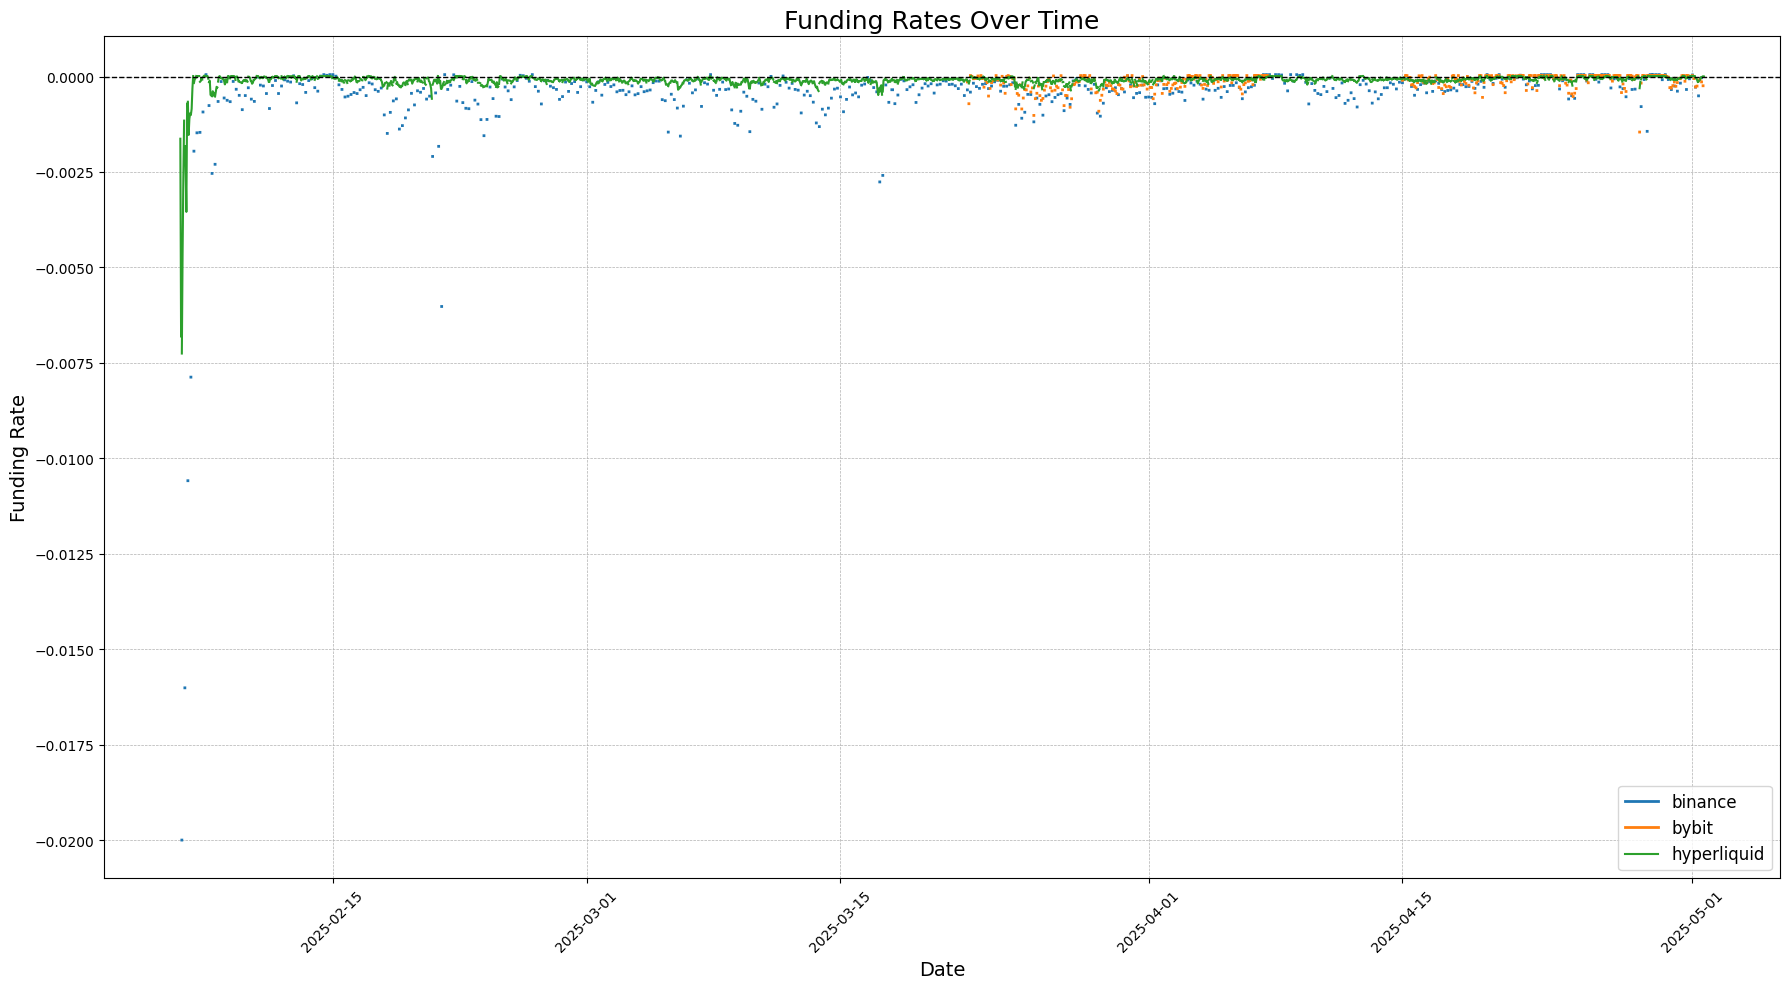

In [ ]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pybit.unified_trading import HTTP

# Initialize Bybit session
bybit_session = HTTP(testnet=False)

# Get listing date for Binance
def get_binance_listing_date(symbol):
    url = "https://fapi.binance.com/fapi/v1/exchangeInfo"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        for s in data["symbols"]:
            if s["symbol"] == symbol:
                listing_date = int(s["onboardDate"])
                print(f"Binance {symbol} listed on {pd.to_datetime(listing_date, unit='ms')}")
                return listing_date
    except Exception as e:
        print(f"Binance listing fetch error: {e}")
    return None

# Get listing date for Bybit
def get_bybit_listing_date(symbol_bybit, bybit_session):
    try:
        response = bybit_session.get_instruments_info(category="linear", symbol=symbol_bybit)
        if response.get("result") and response["result"].get("list"):
            item = response["result"]["list"][0]
            listing_date = int(item["launchTime"])
            print(f"Bybit {symbol_bybit} listed on {pd.to_datetime(listing_date, unit='ms')}")
            return listing_date
    except Exception as e:
        print(f"Bybit listing fetch error: {e}")
    return None

# Hyperliquid listing date (assumed)
def get_hyperliquid_listing_date():
    very_old_date = int(pd.Timestamp('2023-12-03').timestamp() * 1000)
    return very_old_date

# Binance Historical Funding
def get_binance_funding_history(symbol, start_time_ms, end_time_ms=None):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_data = []

    while True:
        params = {
            "symbol": symbol,
            "startTime": start_time_ms,
            "limit": limit
        }
        if end_time_ms is not None:
            params["endTime"] = end_time_ms

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if not data:
                break

            # Add the fetched funding rates
            all_data.extend([
                {"timestamp": int(item["fundingTime"]), "fundingRate": float(item["fundingRate"])}
                for item in data
            ])

            # Move start_time_ms forward to next funding
            start_time_ms = int(data[-1]["fundingTime"]) + 1

            # If we've passed end_time_ms (if provided), break
            if end_time_ms and start_time_ms > end_time_ms:
                break

            # Be polite to API
            time.sleep(1)

        except Exception as e:
            print(f"Binance error: {e}")
            break

    print(f"Binance Fetch Complete ✅ Total funding entries: {len(all_data)}")
    return all_data


# Bybit Historical Funding
def get_bybit_funding_history(symbol_bybit, start_time, end_time, bybit_session):
    all_data = []
    chunk_size_ms = 90 * 24 * 60 * 60 * 1000
    current_start = start_time
    total_duration = end_time - start_time
    last_printed_progress = -1

    while current_start < end_time:
        current_end = min(current_start + chunk_size_ms, end_time)
        try:
            response = bybit_session.get_funding_rate_history(
                category="linear",
                symbol=symbol_bybit,
                startTime=current_start,
                endTime=current_end,
                limit=200
            )
            if response.get("result") and response["result"].get("list"):
                batch = response["result"]["list"]
                all_data.extend([
                    {"timestamp": int(item["fundingRateTimestamp"]), "fundingRate": float(item["fundingRate"])}
                    for item in batch
                ])
                last_timestamp = int(batch[-1]["fundingRateTimestamp"])
                current_start = last_timestamp + (8 * 60 * 60 * 1000)
            else:
                print(f"No more Bybit data after {pd.to_datetime(current_start, unit='ms')}")
                break

            progress = int(100 * (current_start - start_time) / total_duration)
            if progress != last_printed_progress and progress % 5 == 0:
                print(f"Bybit Fetch Progress: {progress}%")
                last_printed_progress = progress

            time.sleep(0.2)
        except Exception as e:
            print(f"Bybit error for {symbol_bybit}: {e}")
            break

    print("Bybit Fetch Complete ✅. Total funding entries:", len(all_data))
    return all_data

# Hyperliquid Historical Funding
def get_hyperliquid_funding_history(coin, start_time_ms, end_time_ms):
    url = "https://api.hyperliquid.xyz/info"
    headers = {"Content-Type": "application/json"}
    all_data = []
    batch_size = 7 * 24 * 60 * 60 * 1000
    current_start = start_time_ms
    total_duration = end_time_ms - start_time_ms
    last_printed_progress = -1

    while current_start < end_time_ms:
        current_end = min(current_start + batch_size, end_time_ms)
        payload = {
            "type": "fundingHistory",
            "coin": coin,
            "startTime": current_start,
            "endTime": current_end
        }
        try:
            response = requests.post(url, headers=headers, json=payload, timeout=10)
            response.raise_for_status()
            batch = response.json()
            if not batch:
                print(f"No data between {pd.to_datetime(current_start, unit='ms')} and {pd.to_datetime(current_end, unit='ms')}")
                current_start = current_end + 1
                continue
            all_data.extend([
                {"timestamp": int(item["time"]), "fundingRate": float(item["fundingRate"])}
                for item in batch
            ])
            current_start = current_end + 1
            progress = int(100 * (current_start - start_time_ms) / total_duration)
            if progress != last_printed_progress and progress % 5 == 0:
                print(f"Hyperliquid Fetch Progress: {progress}%")
                last_printed_progress = progress
            time.sleep(0.1)
        except Exception as e:
            print(f"Hyperliquid error: {e}")
            break

    print("Hyperliquid Fetch Complete ✅. Total funding entries:", len(all_data))
    return all_data

# Fetch historical funding from all sources
def fetch_historical_funding(symbol_binance, symbol_bybit, symbol_hyperliquid):
    now = int(time.time() * 1000)
    binance_listing = get_binance_listing_date(symbol_binance) or (now - 365 * 24 * 60 * 60 * 1000)
    bybit_listing = get_bybit_listing_date(symbol_bybit, bybit_session) or (now - 365 * 24 * 60 * 60 * 1000)
    hyperliquid_listing = binance_listing - 30 * 24 * 60 * 60 * 1000

    start_time_ms = min(binance_listing, bybit_listing, hyperliquid_listing)


    return {
        "binance": get_binance_funding_history(symbol_binance, start_time_ms, now),
        "bybit": get_bybit_funding_history(symbol_bybit, start_time_ms, now, bybit_session),
        "hyperliquid": get_hyperliquid_funding_history(symbol_hyperliquid, start_time_ms, now)
    }

# Convert and plot funding rates
def process_and_plot_funding(funding_histories):
    dfs = {}
    for exchange, history in funding_histories.items():
        df = pd.DataFrame(history)
        if not df.empty:
            df['timestamp'] = pd.to_datetime(pd.to_numeric(df['timestamp'], errors='coerce'), unit='ms')
            df = df.set_index('timestamp')

            # Group by timestamp and mean to avoid duplicates
            df = df.groupby(level=0).mean()

            df = df.rename(columns={"fundingRate": exchange})
            dfs[exchange] = df

    combined = pd.concat(dfs.values(), axis=1)
    combined = combined.sort_index()

    plt.figure(figsize=(18, 10))
    for col in combined.columns:
        if col in ["binance", "bybit"]:
            plt.step(combined.index, combined[col], where="post", label=col, linewidth=2)
        else:
            plt.plot(combined.index, combined[col], label=col, linewidth=1.5)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title("Funding Rates Over Time", fontsize=18)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Funding Rate", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return combined
# Main runner
if __name__ == "__main__":

    funding_histories = fetch_historical_funding(
        symbol_binance,
        symbol_bybit,
        symbol_hyperliquid
    )

    combined_df = process_and_plot_funding(funding_histories)


## Analyzing the funding rates

We do simple annualization, descriptive analysis and some plotting. Next step is OI-weighted data etc.

In [7]:
print(combined_df.tail(10))

                          binance     bybit  hyperliquid
timestamp                                               
2025-05-01 10:00:00.000       NaN -0.000070          NaN
2025-05-01 10:00:00.063       NaN       NaN    -0.000067
2025-05-01 11:00:00.019       NaN       NaN    -0.000042
2025-05-01 12:00:00.000       NaN -0.000141          NaN
2025-05-01 12:00:00.001 -0.000032       NaN          NaN
2025-05-01 12:00:00.140       NaN       NaN    -0.000015
2025-05-01 13:00:00.001       NaN       NaN    -0.000005
2025-05-01 14:00:00.000       NaN -0.000242          NaN
2025-05-01 14:00:00.073       NaN       NaN    -0.000007
2025-05-01 15:00:00.106       NaN       NaN     0.000005


### Data cleaning

In [8]:
# Normalize timestamps to remove milliseconds, keep them exactly on the hour
combined_df.index = combined_df.index.floor('H')
combined_df = combined_df.groupby(combined_df.index).mean()
print(combined_df.tail(20))

                      binance     bybit  hyperliquid
timestamp                                           
2025-04-30 20:00:00 -0.000059  0.000005    -0.000025
2025-04-30 21:00:00       NaN       NaN     0.000013
2025-04-30 22:00:00       NaN  0.000005     0.000013
2025-04-30 23:00:00       NaN       NaN     0.000013
2025-05-01 00:00:00  0.000041  0.000025     0.000013
2025-05-01 01:00:00       NaN       NaN     0.000013
2025-05-01 02:00:00       NaN -0.000054     0.000013
2025-05-01 03:00:00       NaN       NaN     0.000013
2025-05-01 04:00:00 -0.000279 -0.000274    -0.000036
2025-05-01 05:00:00       NaN       NaN    -0.000050
2025-05-01 06:00:00       NaN -0.000250    -0.000089
2025-05-01 07:00:00       NaN       NaN    -0.000141
2025-05-01 08:00:00 -0.000506 -0.000115    -0.000124
2025-05-01 09:00:00       NaN       NaN    -0.000103
2025-05-01 10:00:00       NaN -0.000070    -0.000067
2025-05-01 11:00:00       NaN       NaN    -0.000042
2025-05-01 12:00:00 -0.000032 -0.000141    -0.

/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_83871/3329425146.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined_df.index = combined_df.index.floor('H')


Annualize based on the real data - exchanges can change the funding periods.

In [9]:
def annualize_funding_dynamic(df, col_name):
    """Annualize funding based on actual time gaps between funding payments."""
    funding_times = df[df[col_name].notnull()].index

    # Calculate the difference between funding timestamps (in hours)
    funding_diffs = funding_times.to_series().diff().dt.total_seconds() / 3600

    # Shift diffs backward, so each timestamp gets the correct "period"
    funding_diffs = funding_diffs.shift(-1)

    # Map the hours between fundings back into the DataFrame
    df[f'{col_name}_hours_between_funding'] = funding_diffs

    # Calculate annualized funding rate
    # Annualization factor = (365 * 24) / hours_between
    annualization_factor = (365 * 24) / df[f'{col_name}_hours_between_funding']

    df[f'{col_name}_annualized'] = df[col_name] * annualization_factor

    return df

for col in ['binance', "bybit", 'hyperliquid']:
    combined_df = annualize_funding_dynamic(combined_df, col)
print(combined_df.tail(10))

                      binance     bybit  hyperliquid  \
timestamp                                              
2025-05-01 06:00:00       NaN -0.000250    -0.000089   
2025-05-01 07:00:00       NaN       NaN    -0.000141   
2025-05-01 08:00:00 -0.000506 -0.000115    -0.000124   
2025-05-01 09:00:00       NaN       NaN    -0.000103   
2025-05-01 10:00:00       NaN -0.000070    -0.000067   
2025-05-01 11:00:00       NaN       NaN    -0.000042   
2025-05-01 12:00:00 -0.000032 -0.000141    -0.000015   
2025-05-01 13:00:00       NaN       NaN    -0.000005   
2025-05-01 14:00:00       NaN -0.000242    -0.000007   
2025-05-01 15:00:00       NaN       NaN     0.000005   

                     binance_hours_between_funding  binance_annualized  \
timestamp                                                                
2025-05-01 06:00:00                            NaN                 NaN   
2025-05-01 07:00:00                            NaN                 NaN   
2025-05-01 08:00:00            

In [12]:
import pandas as pd

# Assume your DataFrame is called `combined_df` and timestamp is the index
combined_df.index = pd.to_datetime(combined_df.index)  # ensure datetime index

# Select annualized columns
annualized_cols = ['binance_annualized', "bybit_annualized", 'hyperliquid_annualized']

# Function to compute summary stats
def compute_stats(df_slice):
    stats = df_slice.describe()
    stats.loc['skew'] = df_slice.skew()
    stats.loc['kurtosis'] = df_slice.kurtosis()
    return stats

# Full period
full_stats = compute_stats(combined_df[annualized_cols])

# Past 12 months
last_12m = combined_df.loc[combined_df.index >= (combined_df.index.max() - pd.DateOffset(months=12))]
last_12m_stats = compute_stats(last_12m[annualized_cols])

# Past quarter (3 months)
last_quarter = combined_df.loc[combined_df.index >= (combined_df.index.max() - pd.DateOffset(months=1))]
last_quarter_stats = compute_stats(last_quarter[annualized_cols])

# Print results
print("📊 Summary Statistics for Annualized Funding Rates (All Time):")
print(full_stats)
print("\n📆 Past 12 Months:")
print(last_12m_stats)
print("\n📆 Past 1 Month:")
print(last_quarter_stats)


📊 Summary Statistics for Annualized Funding Rates (All Time):
          binance_annualized  bybit_annualized  hyperliquid_annualized
count             503.000000        399.000000             2017.000000
mean               -1.106229         -0.626054               -0.937980
std                 2.914922          0.862060                2.494274
min               -43.800000         -6.371717              -63.561929
25%                -1.130478         -1.044148               -1.070300
50%                -0.683543         -0.363978               -0.701288
75%                -0.321974          0.109500               -0.365155
max                 0.109500          0.109500                0.232708
skew              -10.833491         -1.940714              -18.129327
kurtosis          136.099116          6.429992              395.987307

📆 Past 12 Months:
          binance_annualized  bybit_annualized  hyperliquid_annualized
count             503.000000        399.000000             2017.000

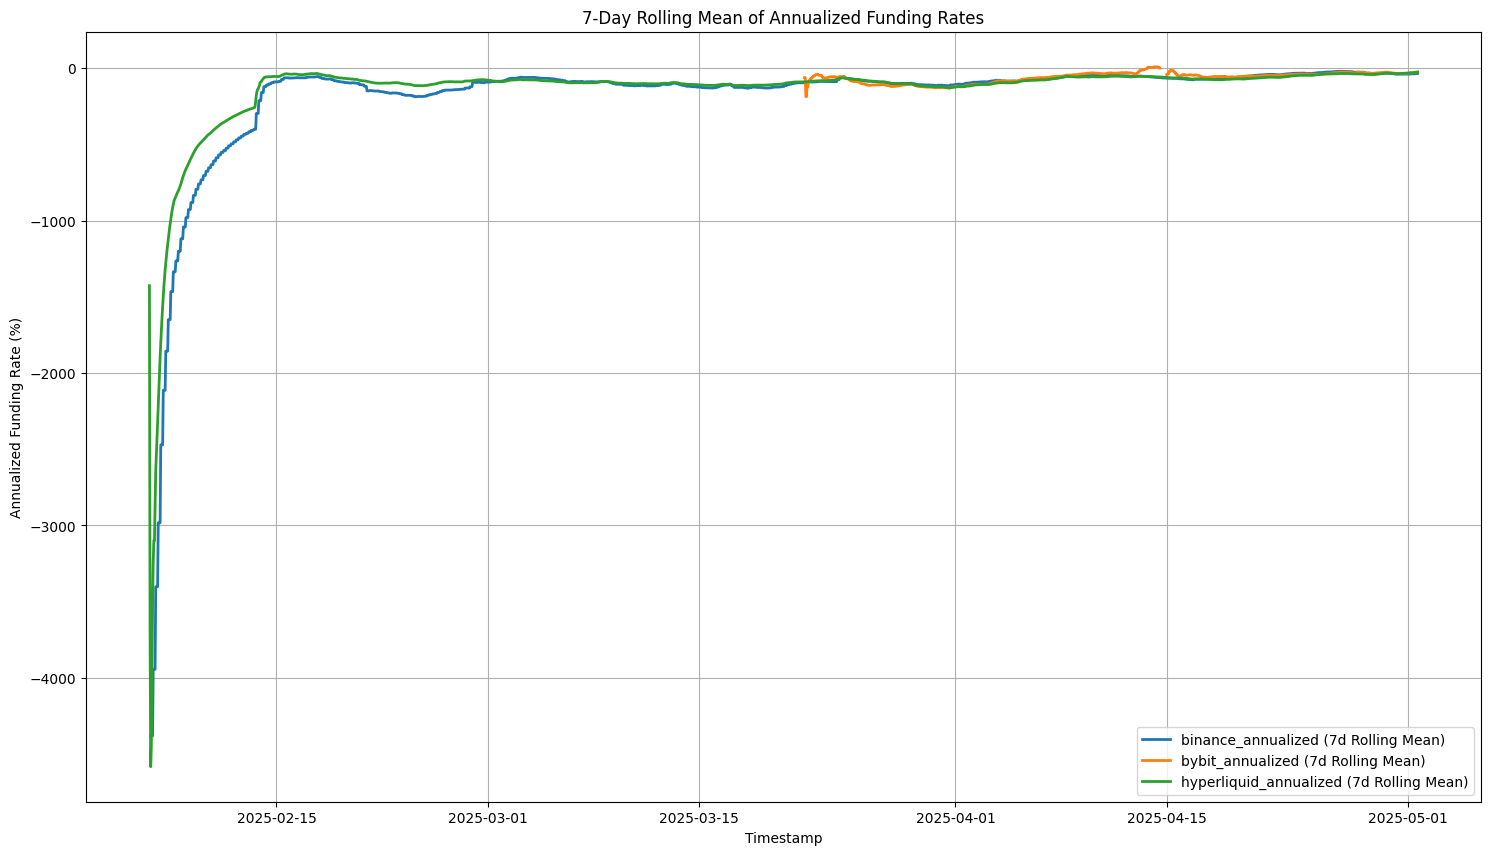

In [14]:
import matplotlib.pyplot as plt

# Define rolling window size (7 days = 168 hours)
rolling_window = 24 * 7

# Calculate 7-day rolling mean
rolling_means = (combined_df[annualized_cols].rolling(window=rolling_window, min_periods=1).mean()*100).round(2)

# Plot
plt.figure(figsize=(18, 10))
for col in annualized_cols:
    plt.plot(rolling_means.index, rolling_means[col], label=f"{col} (7d Rolling Mean)", linewidth=2)

plt.title('7-Day Rolling Mean of Annualized Funding Rates')
plt.xlabel('Timestamp')
plt.ylabel('Annualized Funding Rate (%)')
plt.grid(True)
plt.legend()
plt.show()
